In [ ]:
import torch as th
import numpy as np

BW = 23 # Mbits/s
FPS = 10
PSZ = 4 * 16 # 4 channels of 16 bits each

D_Guaranteed = 2 # meters


MFS = BW/FPS # Maximum Frame Size in Mbits

MAX_POINTS = int(np.min([MFS*1000000/PSZ, 480*480]))



# a tensor 480x480x4  pxl, pxl,(x,y,z,validity)
a = th.rand(480, 480, 4)*20

tic = th.cuda.Event(enable_timing=True)
toc = th.cuda.Event(enable_timing=True)

tic.record()
a = a.view(-1, 4).contiguous()

# validity is inverse of normalized z value

a[:,3] = 1/(a[:,2]/th.max(a[:,2]) + 1e-6)



a[a[:,2] < D_Guaranteed, 3] = th.max(a[:,3])




n_points = a.size(0)

# sample the point cloud using multinomial based on the validity

valid_indexes = th.multinomial(a[:,3], MAX_POINTS, replacement=False)

valid_points = a[valid_indexes]

frame_size = PSZ * valid_points.size(0)

toc.record()
th.cuda.synchronize()

print("elapsed time: ", tic.elapsed_time(toc), "ms")





elapsed time:  3.630079984664917 ms


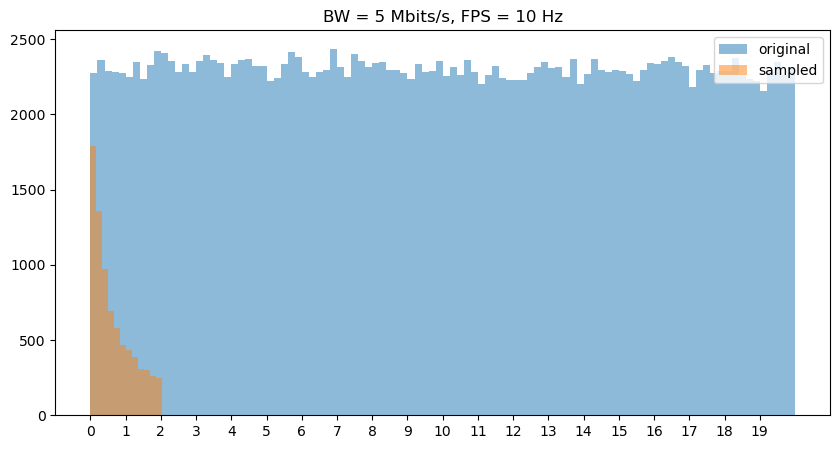

grabbed point cloud has 230400 points
to transmit it would be required a bandwidth of 147.456 Mbits/s
with a BW of 5 Mbits/s and FPS of 10 the maximum number of points that can be transmitted is 7812.5
points selected for transmission 7812


In [8]:
sample = valid_points[th.randint(0, valid_points.size(0), (1,))]

#print(valid_points)




# print cdf on z for original and sampled point cloud

import matplotlib.pyplot as plt

# plot with size of plot 5x2

plt.figure(figsize=(10, 5))

plt.title("BW = "+str(BW)+" Mbits/s, FPS = "+str(FPS)+" Hz")

plt.hist(a[:,2].numpy(), bins=100, alpha=0.5, label='original')
plt.hist(valid_points[:,2].numpy(), bins=100, alpha=0.5, label='sampled')
plt.legend(loc='upper right')
# finer ticks
plt.xticks(np.arange(0, 20, 1))


plt.show()





print("grabbed point cloud has", n_points, "points")
print("to transmit it would be required a bandwidth of", n_points*PSZ*FPS/1000000, "Mbits/s")

print("with a BW of", BW, "Mbits/s and FPS of", FPS, "the maximum number of points that can be transmitted is", MFS*1000000/PSZ)

print("points selected for transmission", valid_points.size(0))


